In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import kagglehub
# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [3]:
# Load Dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
labels_file = "/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt"
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [4]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

In [5]:
# Load Images and Labels
data = []
labels = []
for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

In [6]:
# Encode Labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [7]:
#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [9]:
# Learning Rate Scheduler and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
# Model Architectures
def build_model(base_model, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(32, activation='elu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Initialize models
vgg_base = VGG16(include_top=False, input_shape=(224, 224, 3))
effnet_base = EfficientNetB3(include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

In [13]:
# Build Models
model_vgg = build_model(vgg_base, len(animal_names))
model_effnet = build_model(effnet_base, len(animal_names))
model_mobilenet = build_model(mobilenet_base, len(animal_names))

In [18]:
# Function to Train and Plot History
def train_and_plot(model, x_train, y_train, x_val, y_val, model_name):
    history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=50, 
                        validation_data=datagen.flow(x_val, y_val), 
                        callbacks=[lr_scheduler, early_stopping], verbose=2)
    
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    
    return model, history

Epoch 1/50


I0000 00:00:1731209104.511759    2186 service.cc:145] XLA service 0x7d0dbc00e100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731209104.511822    2186 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731209104.511829    2186 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731209117.539951    2186 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 - 67s - 548ms/step - accuracy: 0.0291 - loss: 4.4573 - val_accuracy: 0.0903 - val_loss: 4.3558 - learning_rate: 0.0010
Epoch 2/50
122/122 - 43s - 351ms/step - accuracy: 0.0854 - loss: 4.2435 - val_accuracy: 0.0995 - val_loss: 4.1350 - learning_rate: 0.0010
Epoch 3/50
122/122 - 43s - 350ms/step - accuracy: 0.1245 - loss: 3.9559 - val_accuracy: 0.1620 - val_loss: 3.8406 - learning_rate: 0.0010
Epoch 4/50
122/122 - 43s - 348ms/step - accuracy: 0.1772 - loss: 3.6645 - val_accuracy: 0.1782 - val_loss: 3.6099 - learning_rate: 0.0010
Epoch 5/50
122/122 - 43s - 349ms/step - accuracy: 0.2207 - loss: 3.4077 - val_accuracy: 0.2153 - val_loss: 3.3728 - learning_rate: 0.0010
Epoch 6/50
122/122 - 43s - 349ms/step - accuracy: 0.2479 - loss: 3.2098 - val_accuracy: 0.2384 - val_loss: 3.2393 - learning_rate: 0.0010
Epoch 7/50
122/122 - 42s - 347ms/step - accuracy: 0.2837 - loss: 3.0427 - val_accuracy: 0.2801 - val_loss: 3.0951 - learning_rate: 0.0010
Epoch 8/50
122/122 - 42s - 347ms/step - accur

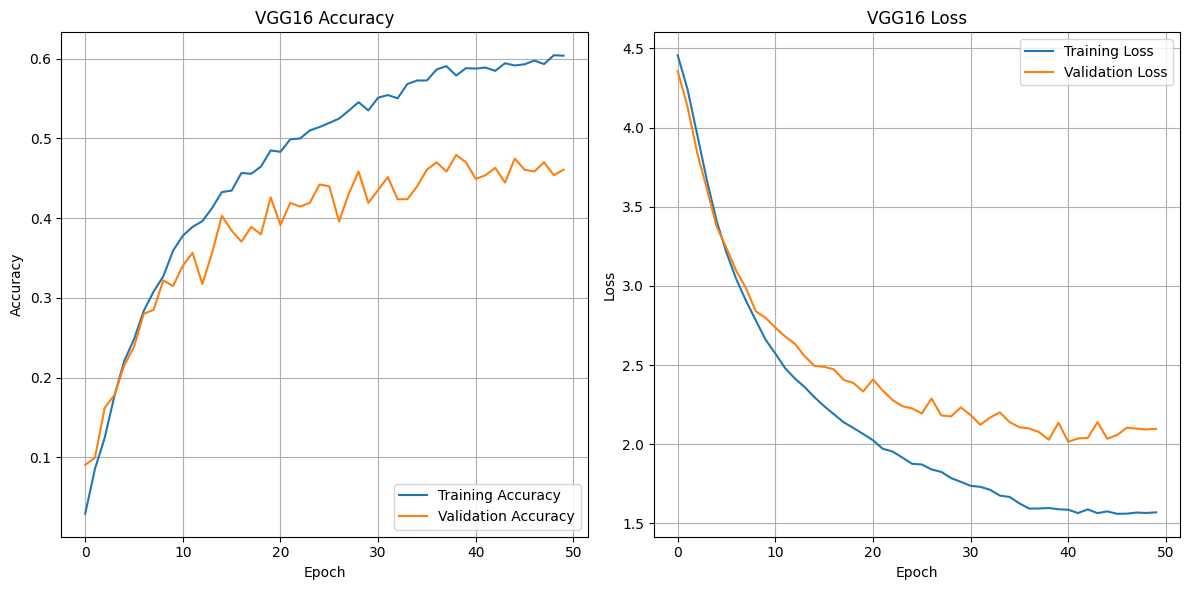

In [19]:
# Train Models
model_vgg, vgg_history = train_and_plot(model_vgg, x_train, y_train, x_val, y_val, 'VGG16')


Epoch 1/50


I0000 00:00:1731205239.477282    1061 service.cc:145] XLA service 0x79576c02b4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731205239.477332    1061 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731205239.477335    1061 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731205279.779711    1061 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 - 146s - 1s/step - accuracy: 0.0134 - loss: 4.5387 - val_accuracy: 0.0046 - val_loss: 4.5124 - learning_rate: 0.0010
Epoch 2/50
122/122 - 42s - 345ms/step - accuracy: 0.0100 - loss: 4.5350 - val_accuracy: 0.0139 - val_loss: 4.5322 - learning_rate: 0.0010
Epoch 3/50
122/122 - 42s - 346ms/step - accuracy: 0.0111 - loss: 4.5347 - val_accuracy: 0.0116 - val_loss: 4.5100 - learning_rate: 0.0010
Epoch 4/50
122/122 - 42s - 347ms/step - accuracy: 0.0100 - loss: 4.5285 - val_accuracy: 0.0116 - val_loss: 4.5155 - learning_rate: 0.0010
Epoch 5/50
122/122 - 42s - 346ms/step - accuracy: 0.0116 - loss: 4.5249 - val_accuracy: 0.0116 - val_loss: 4.5348 - learning_rate: 0.0010
Epoch 6/50
122/122 - 42s - 347ms/step - accuracy: 0.0103 - loss: 4.5221 - val_accuracy: 0.0139 - val_loss: 4.5058 - learning_rate: 0.0010
Epoch 7/50
122/122 - 42s - 347ms/step - accuracy: 0.0082 - loss: 4.5203 - val_accuracy: 0.0069 - val_loss: 4.5146 - learning_rate: 0.0010
Epoch 8/50
122/122 - 42s - 345ms/step - accurac

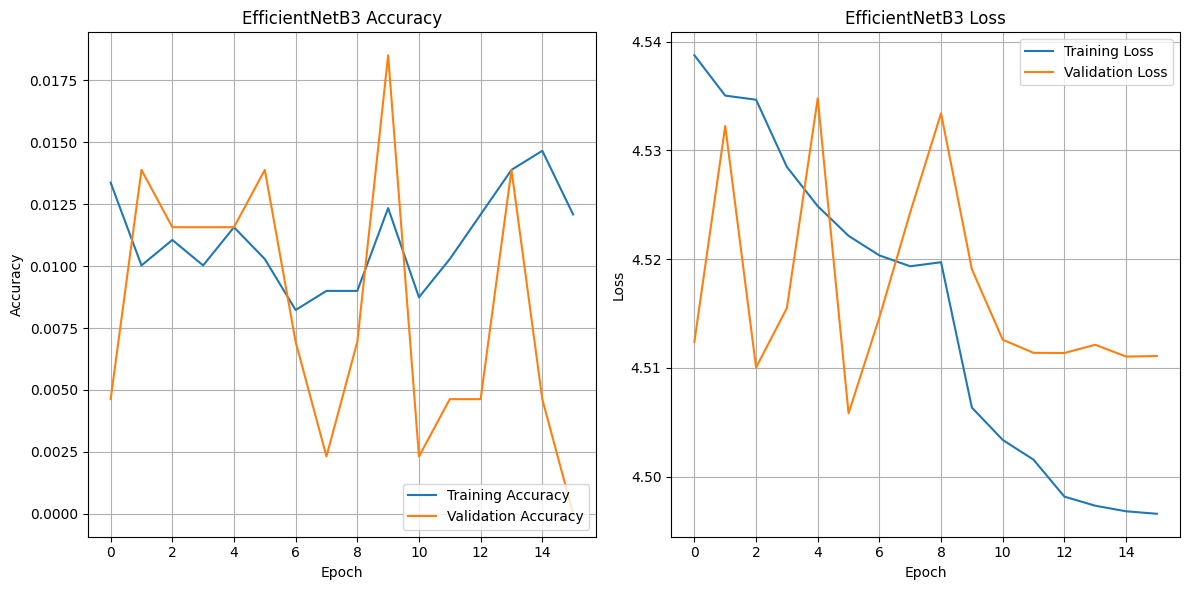

In [13]:
model_effnet, effnet_history = train_and_plot(model_effnet, x_train, y_train, x_val, y_val, 'EfficientNetB3')


Epoch 1/50
122/122 - 58s - 477ms/step - accuracy: 0.2557 - loss: 3.5419 - val_accuracy: 0.5370 - val_loss: 2.4256 - learning_rate: 0.0010
Epoch 2/50
122/122 - 41s - 339ms/step - accuracy: 0.6265 - loss: 1.7076 - val_accuracy: 0.6505 - val_loss: 1.5240 - learning_rate: 0.0010
Epoch 3/50
122/122 - 41s - 339ms/step - accuracy: 0.7436 - loss: 1.0696 - val_accuracy: 0.6991 - val_loss: 1.2099 - learning_rate: 0.0010
Epoch 4/50
122/122 - 42s - 341ms/step - accuracy: 0.7886 - loss: 0.8274 - val_accuracy: 0.7315 - val_loss: 1.0723 - learning_rate: 0.0010
Epoch 5/50
122/122 - 42s - 340ms/step - accuracy: 0.8143 - loss: 0.7065 - val_accuracy: 0.7384 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 6/50
122/122 - 41s - 336ms/step - accuracy: 0.8313 - loss: 0.6116 - val_accuracy: 0.7130 - val_loss: 1.0633 - learning_rate: 0.0010
Epoch 7/50
122/122 - 41s - 339ms/step - accuracy: 0.8529 - loss: 0.5362 - val_accuracy: 0.7523 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 8/50
122/122 - 42s - 341ms/s

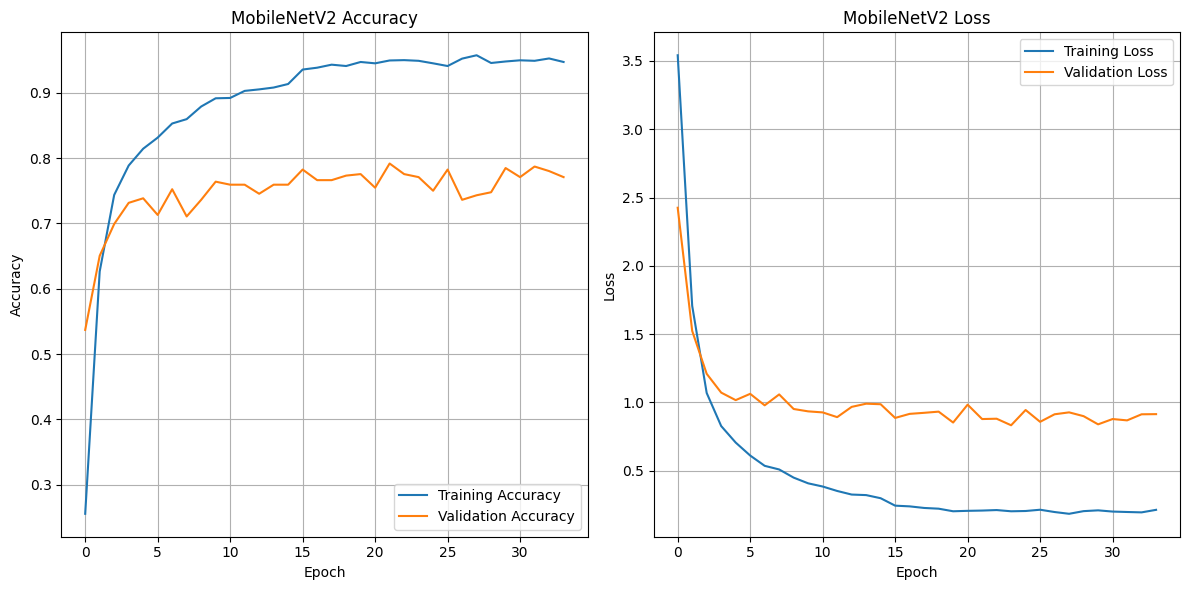

In [14]:
model_mobilenet, mobilenet_history = train_and_plot(model_mobilenet, x_train, y_train, x_val, y_val, 'MobileNetV2')


In [20]:
# Evaluation Function
def evaluate_model(model, x_test, y_test, model_name):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step
Classification Report for VGG16:
                 precision    recall  f1-score   support

      antelope       0.33      0.45      0.38        11
        badger       0.00      0.00      0.00        19
           bat       0.44      0.36      0.40        11
          bear       0.15      0.15      0.15        13
           bee       0.67      0.75      0.71        16
        beetle       0.41      0.82      0.55        11
         bison       0.41      0.58      0.48        12
          boar       0.23      0.19      0.21        16
     butterfly       0.69      0.75      0.72        12
           cat       0.60      0.46      0.52        13
   caterpillar       0.58      0.64      0.61        11
    chimpanzee       0.71      0.42      0.53        12
     cockroach       0.85      0.73      0.79        15
           cow       0.39      0.47      0.42        15
        coyote       0.30      0.27      0.29        11
          crab       0.58  

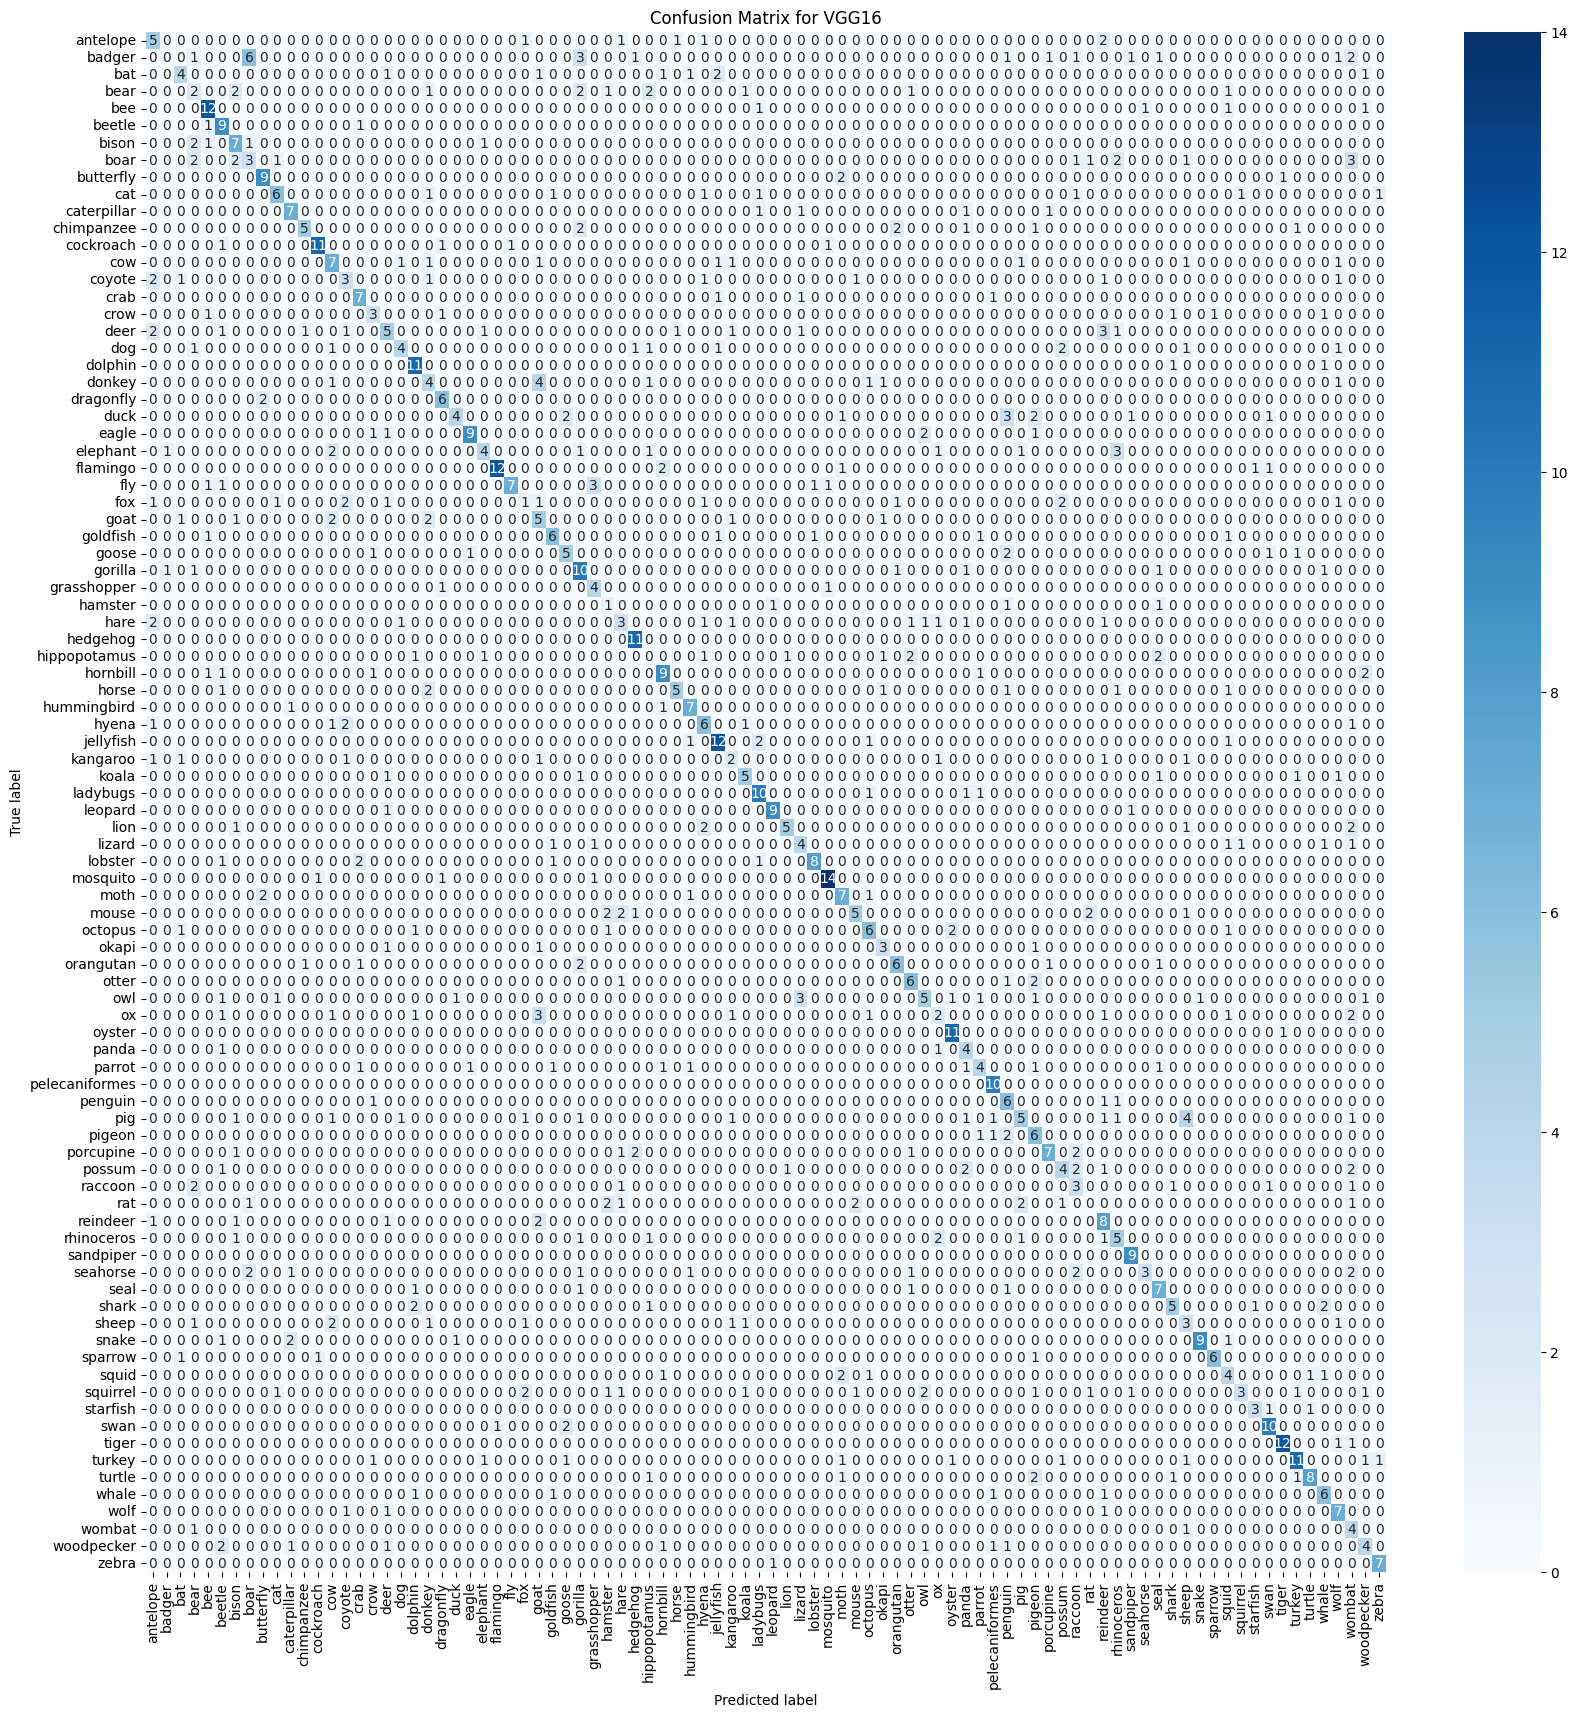

In [21]:
# Evaluate each model
evaluate_model(model_vgg, x_test, y_test, 'VGG16')


34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step
Classification Report for EfficientNetB3:
                 precision    recall  f1-score   support

      antelope       0.00      0.00      0.00        11
        badger       0.00      0.00      0.00        19
           bat       0.00      0.00      0.00        11
          bear       0.00      0.00      0.00        13
           bee       0.00      0.00      0.00        16
        beetle       0.00      0.00      0.00        11
         bison       0.00      0.00      0.00        12
          boar       0.00      0.00      0.00        16
     butterfly       0.00      0.00      0.00        12
           cat       0.00      0.00      0.00        13
   caterpillar       0.00      0.00      0.00        11
    chimpanzee       0.00      0.00      0.00        12
     cockroach       0.00      0.00      0.00        15
           cow       0.00      0.00      0.00        15
        coyote       0.00      0.00      0.00        11
          crab    

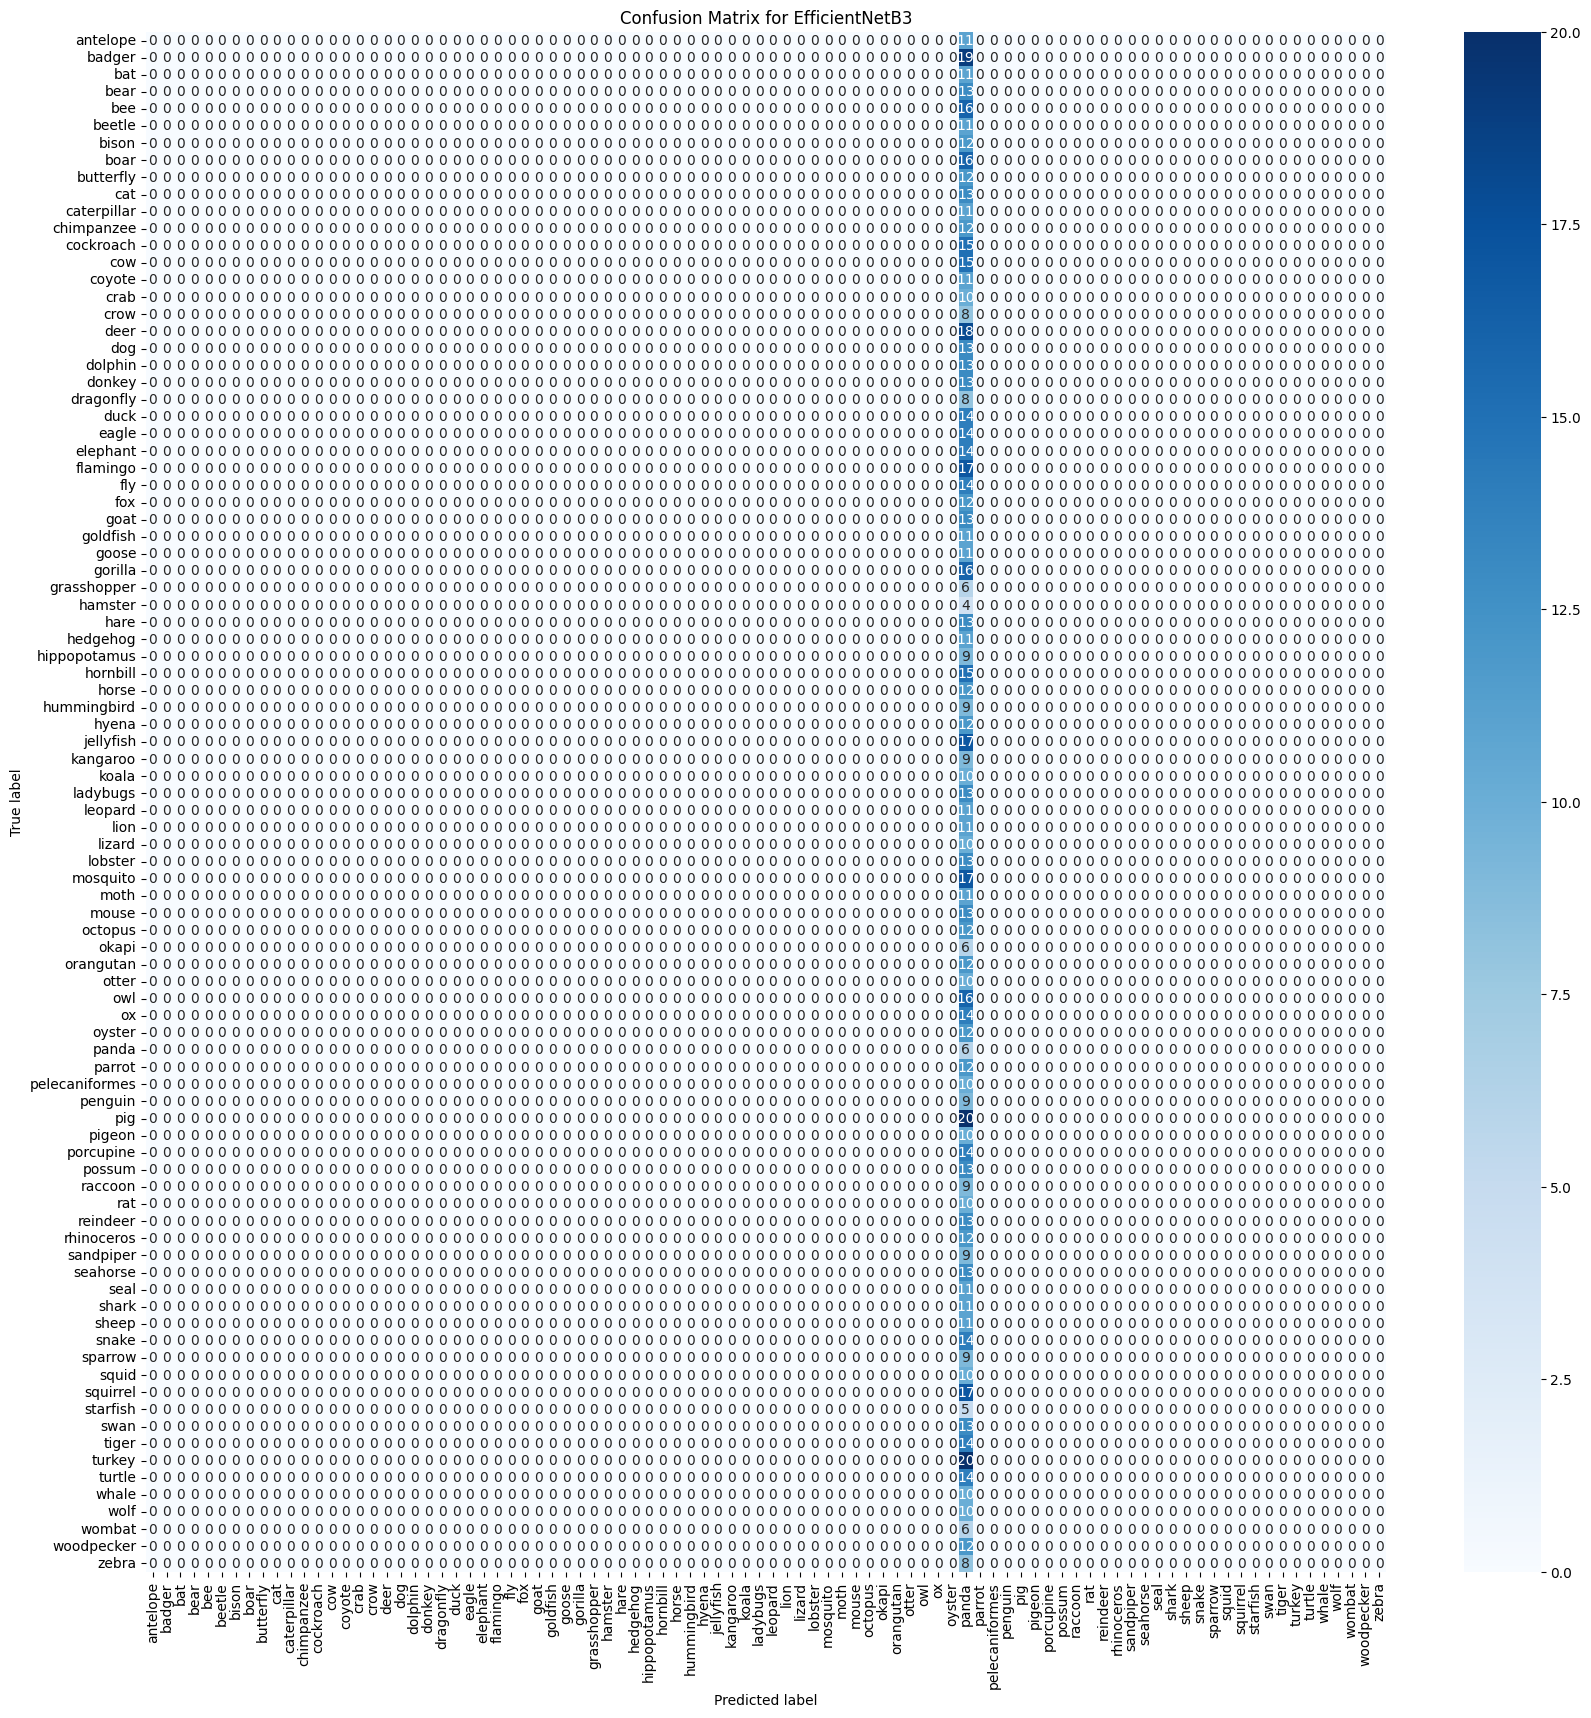

In [19]:
evaluate_model(model_effnet, x_test, y_test, 'EfficientNetB3')

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step
Classification Report for MobileNetV2:
                 precision    recall  f1-score   support

      antelope       0.57      0.73      0.64        11
        badger       0.94      0.89      0.92        19
           bat       0.80      0.73      0.76        11
          bear       0.83      0.77      0.80        13
           bee       0.83      0.94      0.88        16
        beetle       0.79      1.00      0.88        11
         bison       0.83      0.83      0.83        12
          boar       0.73      0.69      0.71        16
     butterfly       0.77      0.83      0.80        12
           cat       0.91      0.77      0.83        13
   caterpillar       0.90      0.82      0.86        11
    chimpanzee       0.85      0.92      0.88        12
     cockroach       1.00      0.93      0.97        15
           cow       0.83      0.67      0.74        15
        coyote       0.67      0.73      0.70        11
          crab       1

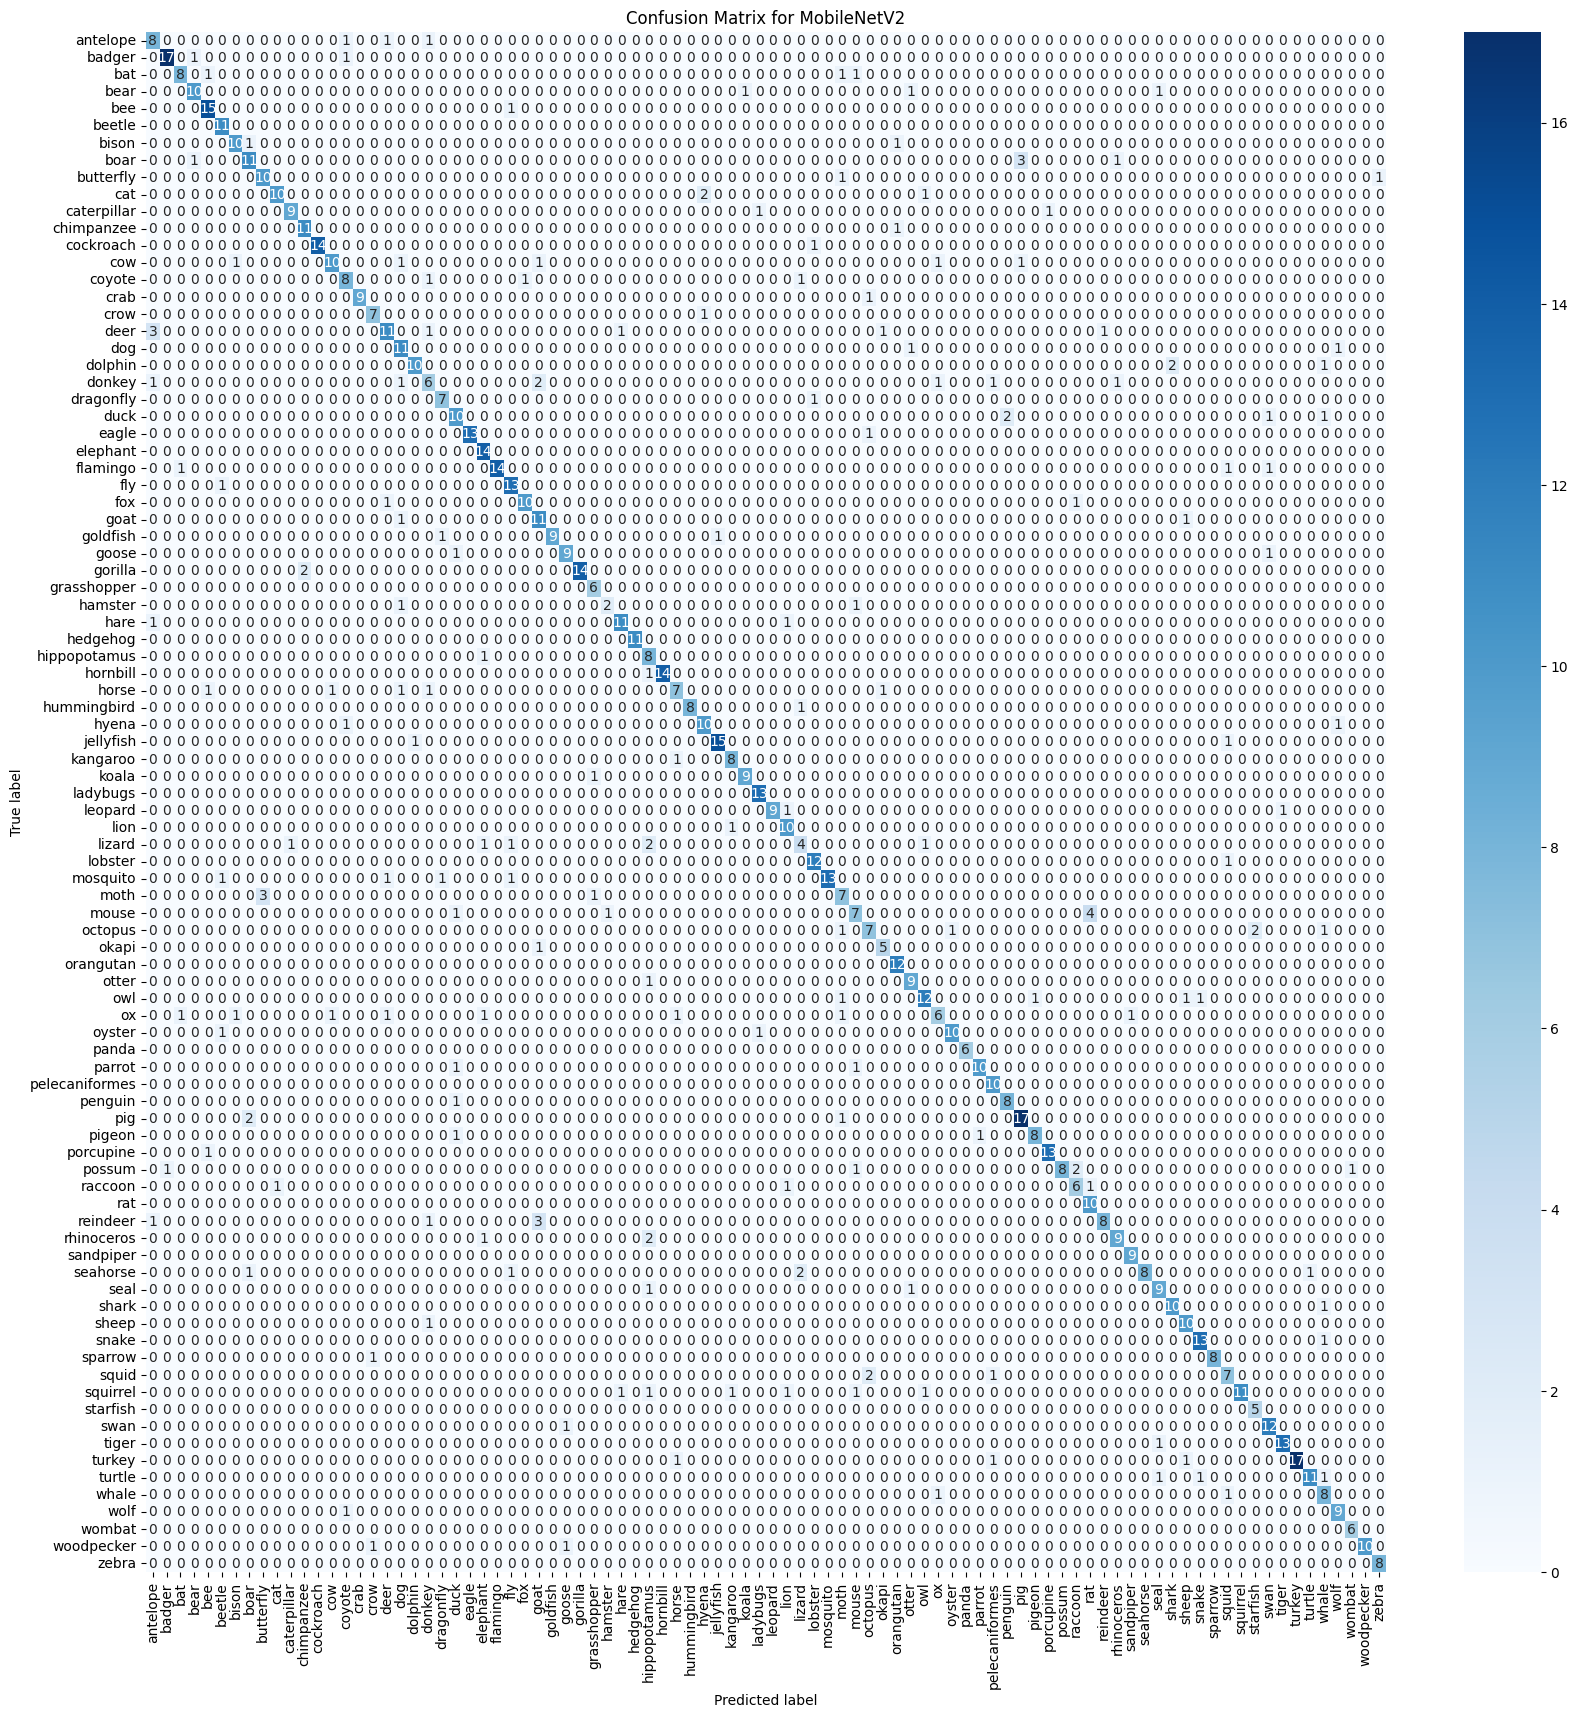

In [21]:
evaluate_model(model_mobilenet, x_test, y_test, 'MobileNetV2')

Epoch 1/50
122/122 - 63s - 513ms/step - accuracy: 0.0195 - loss: 4.5034 - val_accuracy: 0.0509 - val_loss: 4.3936 - learning_rate: 1.0000e-05
Epoch 2/50
122/122 - 44s - 358ms/step - accuracy: 0.0679 - loss: 4.2453 - val_accuracy: 0.0949 - val_loss: 4.1125 - learning_rate: 1.0000e-05
Epoch 3/50
122/122 - 43s - 356ms/step - accuracy: 0.1368 - loss: 3.8872 - val_accuracy: 0.1481 - val_loss: 3.8286 - learning_rate: 1.0000e-05
Epoch 4/50
122/122 - 43s - 355ms/step - accuracy: 0.1932 - loss: 3.5924 - val_accuracy: 0.1852 - val_loss: 3.6393 - learning_rate: 1.0000e-05
Epoch 5/50
122/122 - 44s - 357ms/step - accuracy: 0.2459 - loss: 3.3675 - val_accuracy: 0.2292 - val_loss: 3.4504 - learning_rate: 1.0000e-05
Epoch 6/50
122/122 - 43s - 354ms/step - accuracy: 0.2899 - loss: 3.1371 - val_accuracy: 0.2546 - val_loss: 3.3707 - learning_rate: 1.0000e-05
Epoch 7/50
122/122 - 43s - 356ms/step - accuracy: 0.3292 - loss: 2.9439 - val_accuracy: 0.2778 - val_loss: 3.2254 - learning_rate: 1.0000e-05
Epoch 

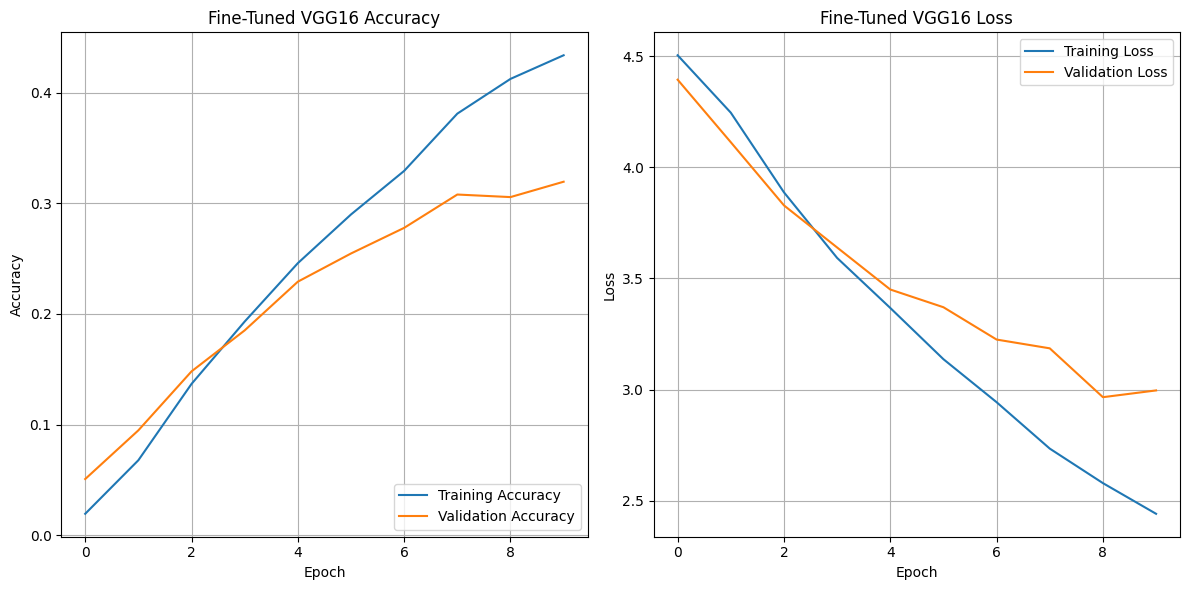

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step
Classification Report for Fine-Tuned VGG16:
                 precision    recall  f1-score   support

      antelope       0.00      0.00      0.00        11
        badger       0.00      0.00      0.00        19
           bat       0.00      0.00      0.00        11
          bear       0.00      0.00      0.00        13
           bee       0.00      0.00      0.00        16
        beetle       0.00      0.00      0.00        11
         bison       0.00      0.00      0.00        12
          boar       0.00      0.00      0.00        16
     butterfly       0.50      0.08      0.14        12
           cat       0.00      0.00      0.00        13
   caterpillar       0.00      0.00      0.00        11
    chimpanzee       0.00      0.00      0.00        12
     cockroach       0.00      0.00      0.00        15
           cow       0.00      0.00      0.00        15
        coyote       0.00      0.00      0.00        11
          crab   

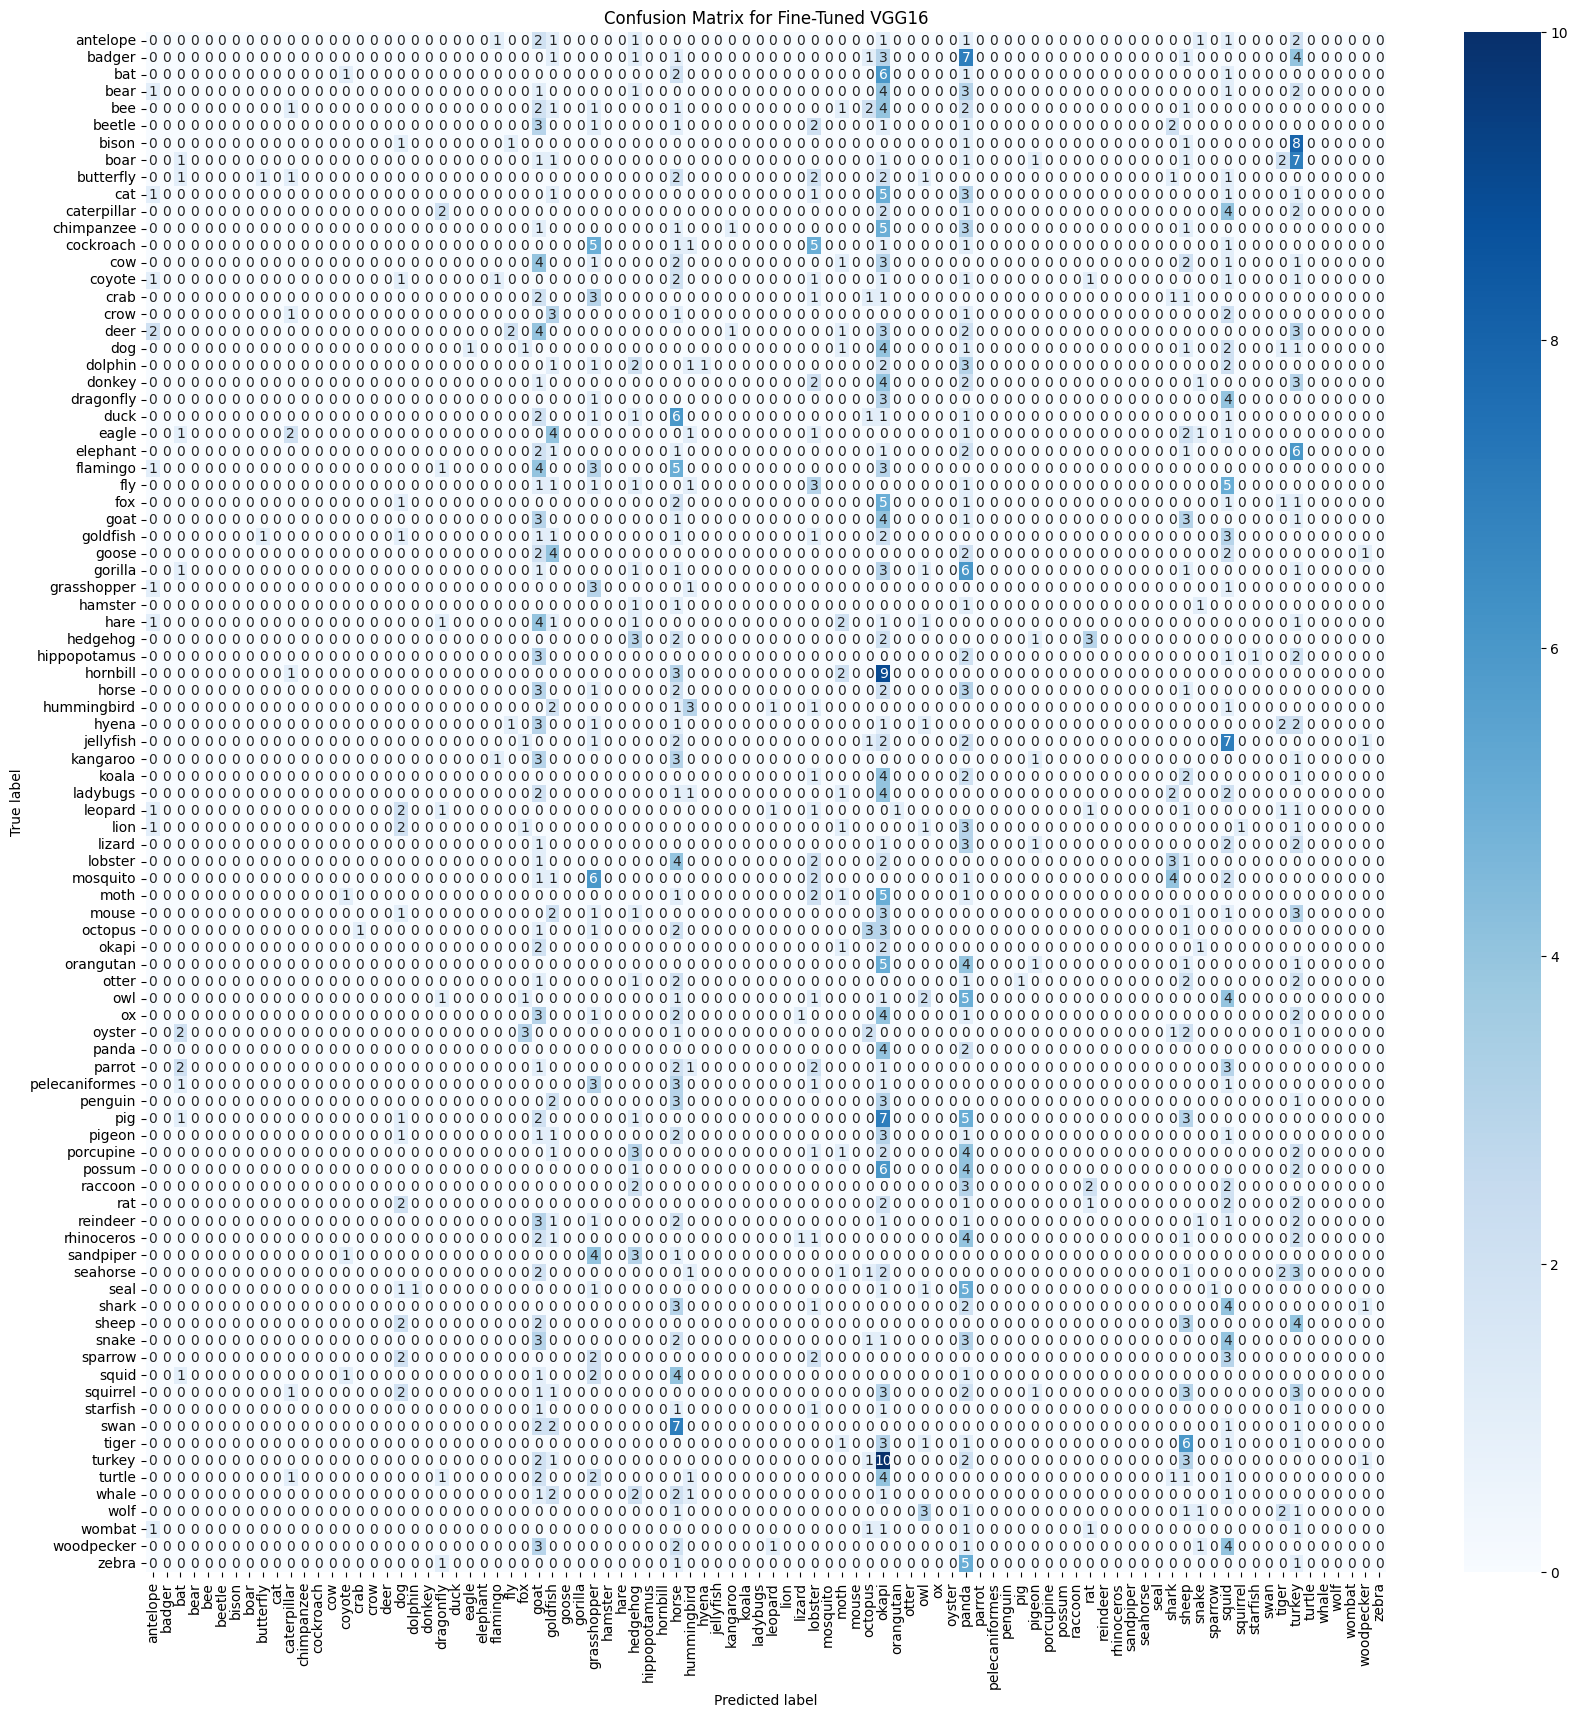

In [22]:
# Fine-tuning on VGG16
for layer in vgg_base.layers[-10:]:
    layer.trainable = True

model_vgg_fine = build_model(vgg_base, len(animal_names))
model_vgg_fine.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg_fine, vgg_fine_history = train_and_plot(model_vgg_fine, x_train, y_train, x_val, y_val, 'Fine-Tuned VGG16')
evaluate_model(model_vgg_fine, x_test, y_test, 'Fine-Tuned VGG16')